# Models intro

- CNN and RNN models
- Use a single stock as data, would require different model on different stock
- Multi category includes sell, neutral, buy classes
- Binary category includes non-buy, buy classes


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf
import talib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.metrics import Precision, AUC


import scripts.feature as feat
import scripts.utility as util


# Single ticker

In [2]:
ticker = "TSLA"
df = yf.download(ticker, period="5y", interval="1d", progress=False)
df = df.drop(columns=["Adj Close"])

# entry = feat.objective(df, days=5, threshold=0.05)
# df["entry"] = entry.values


In [3]:
entry = feat.objective(df, days=5, threshold=0.05)
df = feat.feature_engineering(df)
df["entry"] = entry.values
df = df.dropna()

train, val = util.split_train_val(df, 0.8)


X_train, y_train = util.split_window(train.drop(columns=["entry"]), train["entry"], sequence_length=15)
X_val, y_val = util.split_window(val.drop(columns=["entry"]), val["entry"], sequence_length=15)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(965, 15, 25) (965,)
(231, 15, 25) (231,)


## Multi-category case


In [4]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array([0, 1, 2], dtype=int64), array([384, 106, 475], dtype=int64))
(array([0, 1, 2], dtype=int64), array([102,  49,  80], dtype=int64))


In [5]:
class_weight = {0: 1.5, 1: 1., 2:2.}


### CNN

In [6]:
multi_cat_cnn = Sequential(
    [
        Conv1D(
            filters=32, kernel_size=3, activation="relu", input_shape=X_train.shape[1:]
        ),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),  # 3 classes for classification
    ]
)

multi_cat_cnn.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


c:\Users\edton\miniconda3\envs\trading\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4671 - loss: 1.7124 - val_accuracy: 0.3377 - val_loss: 1.1681
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5112 - loss: 1.4317 - val_accuracy: 0.3506 - val_loss: 1.1352
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5219 - loss: 1.3772 - val_accuracy: 0.3420 - val_loss: 1.1335
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5076 - loss: 1.3943 - val_accuracy: 0.3160 - val_loss: 1.1948
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5384 - loss: 1.3764 - val_accuracy: 0.3203 - val_loss: 1.1718
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5420 - loss: 1.3376 - val_accuracy: 0.3074 - val_loss: 1.1519
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5380 - loss: 1.3485 - val_accuracy: 0.3247 - val_loss: 1.1849
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6110 - loss: 1.2691 - val_accuracy: 0.3593 - val_loss

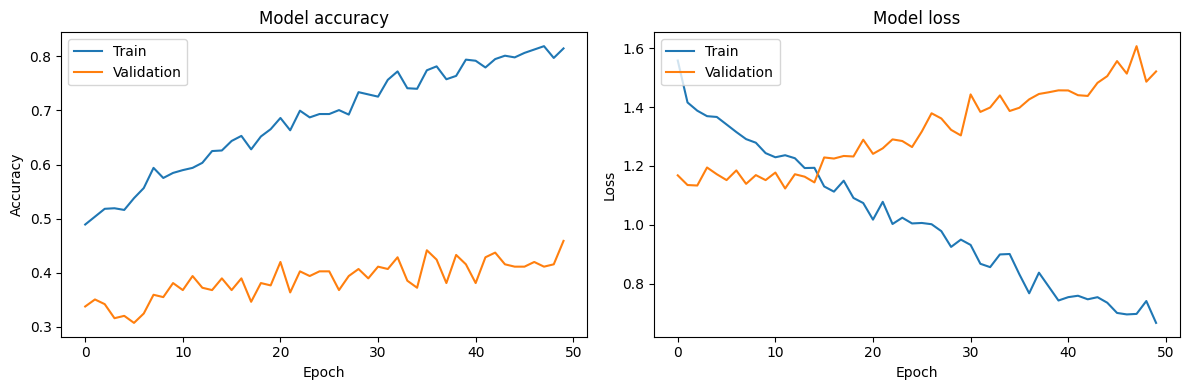

In [7]:
history = multi_cat_cnn.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weight
)

util.plot_training_result(history)

### RNN

In [8]:
multi_cat_rnn = Sequential(
    [
        LSTM(
            64, activation="relu", input_shape=X_train.shape[1:], return_sequences=True
        ),
        LSTM(32, activation="relu"),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax"),  # 3 classes for classification
    ]
)

multi_cat_rnn.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


c:\Users\edton\miniconda3\envs\trading\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4807 - loss: 1.6197 - val_accuracy: 0.3550 - val_loss: 1.1518
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4761 - loss: 1.4272 - val_accuracy: 0.3420 - val_loss: 1.1638
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5170 - loss: 1.3928 - val_accuracy: 0.3463 - val_loss: 1.1552
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4955 - loss: 1.3553 - val_accuracy: 0.3463 - val_loss: 1.1524
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5284 - loss: 1.3390 - val_accuracy: 0.3463 - val_loss: 1.1387
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5575 - loss: 1.2956 - val_accuracy: 0.3420 - val_loss: 1.1550
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5259 - loss: 1.3315 - val_accuracy: 0.3377 - val_loss: 1.2168
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5561 - loss: 1.2849 - val_accuracy: 0.3377 - val_lo

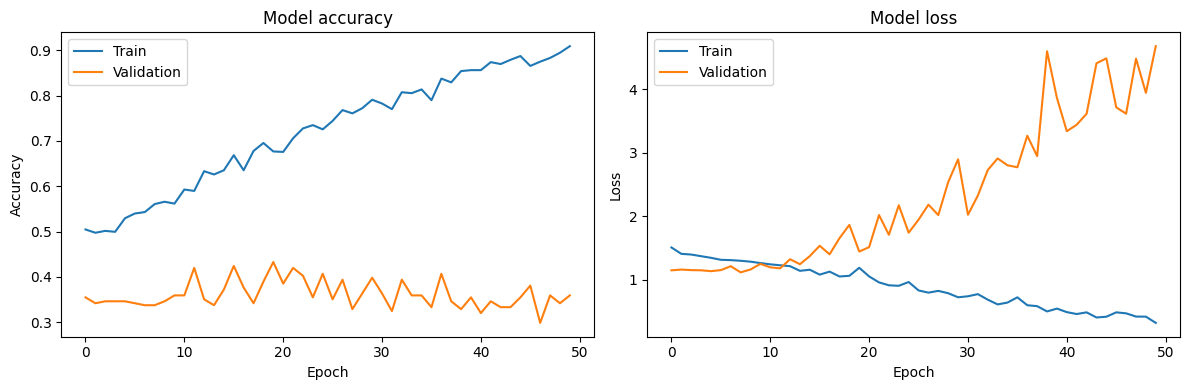

In [9]:
history = multi_cat_rnn.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    class_weight=class_weight
)

util.plot_training_result(history)

## Binary case

In [10]:
y_train_binary = np.where(y_train <= 1, 0, 1)
y_val_binary = np.where(y_val <= 1, 0, 1)
print(np.unique(y_train_binary, return_counts=True))
print(np.unique(y_val_binary, return_counts=True))

(array([0, 1]), array([490, 475], dtype=int64))
(array([0, 1]), array([151,  80], dtype=int64))


In [11]:
class_weight = {0: 1., 1: 2.}

### CNN

In [12]:
binary_cat_cnn = Sequential(
    [
        Conv1D(
            filters=32, kernel_size=3, activation="relu", input_shape=X_train.shape[1:]
        ),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),  # 1 classes for binary
    ]
)

binary_cat_cnn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],  
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5164 - loss: 0.9997 - val_accuracy: 0.3290 - val_loss: 0.7635
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5263 - loss: 0.9557 - val_accuracy: 0.3463 - val_loss: 0.7712
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5074 - loss: 0.9391 - val_accuracy: 0.3290 - val_loss: 0.7541
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5186 - loss: 0.9310 - val_accuracy: 0.3333 - val_loss: 0.8208
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5139 - loss: 0.9051 - val_accuracy: 0.3333 - val_loss: 0.8156
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5147 - loss: 0.9068 - val_accuracy: 0.3247 - val_loss: 0.8205
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5510 - loss: 0.8644 - val_accuracy: 0.3680 - val_loss: 0.7862
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5684 - loss: 0.8696 - val_accuracy: 0.3377 - val_loss

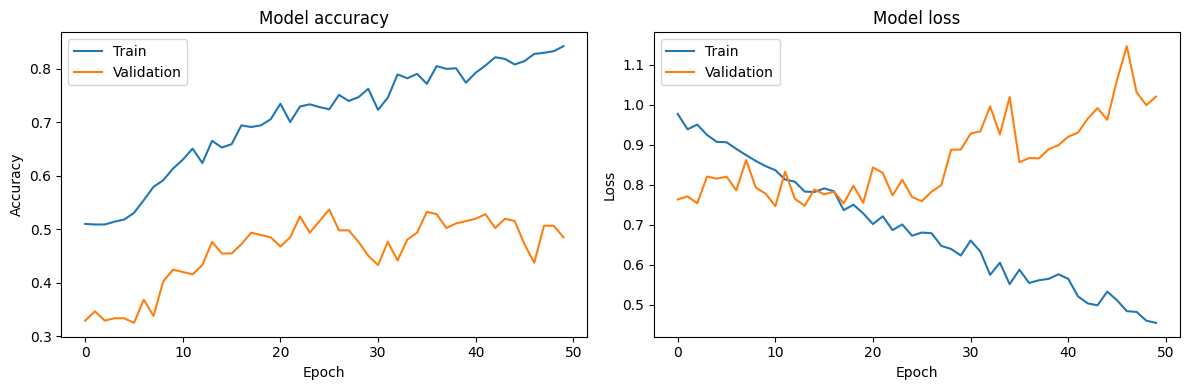

In [13]:
history = binary_cat_cnn.fit(
    X_train, y_train_binary,
    epochs=50,
    validation_data=(X_val, y_val_binary),
    batch_size=32,
    class_weight=class_weight
)

util.plot_training_result(history)

### RNN

In [14]:
binary_cat_rnn = Sequential(
    [
        LSTM(
            64, activation="relu", input_shape=X_train.shape[1:], return_sequences=True
        ),
        LSTM(32, activation="relu"),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(3, activation="sigmoid"),  # 3 classes for classification
    ]
)

binary_cat_rnn.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4605 - loss: 1.2242 - val_accuracy: 0.3463 - val_loss: 0.7854
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4912 - loss: 0.9647 - val_accuracy: 0.3463 - val_loss: 0.7992
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4953 - loss: 0.9381 - val_accuracy: 0.3463 - val_loss: 0.8007
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4866 - loss: 0.9247 - val_accuracy: 0.3463 - val_loss: 0.8188
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4839 - loss: 0.9214 - val_accuracy: 0.3463 - val_loss: 0.7730
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5156 - loss: 0.9406 - val_accuracy: 0.3463 - val_loss: 0.7390
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4900 - loss: 0.9344 - val_accuracy: 0.3506 - val_loss: 0.7390
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4993 - loss: 0.9140 - val_accuracy: 0.3506 - va

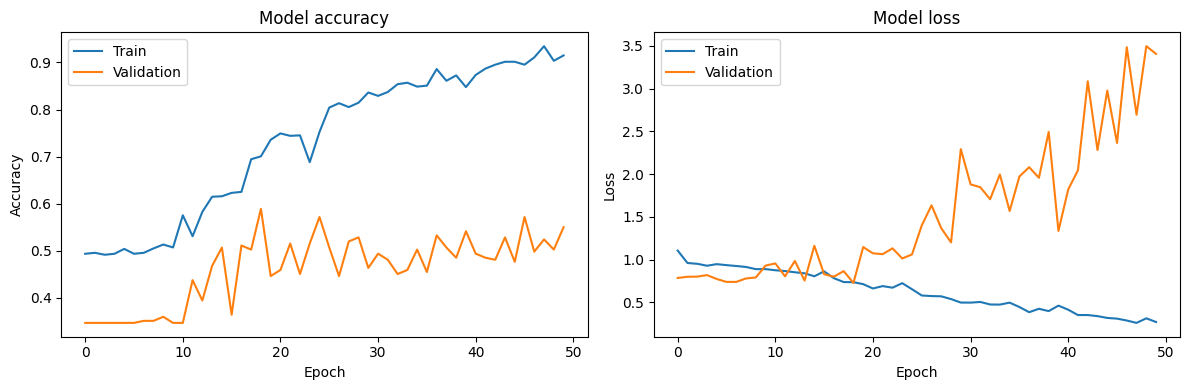

In [15]:
history = binary_cat_rnn.fit(
    X_train, y_train_binary,
    epochs=50,
    validation_data=(X_val, y_val_binary),
    batch_size=32,
    class_weight=class_weight
)

util.plot_training_result(history)